**Notebook information:**

This notebook is designed to reproduce (re-generate) the figures (Python version) provided in the main manuscript and supplementary materials. A separate R-codebase is used to modify (improve) these figures. We will assume at least the following: (0) The data is available in relevant directories; (1) The Camformer models are trained in cases where the code loads a saved model; (3) Base code libraries are available within "./base". The generated figures (and sometimes, their associated data) will be saved into "manuscript/". Due to the size constraints, we are not able to upload the raw datasets, but we have made efforts to list them or provide their URLs. 

For additional clarity, reach out to the authors: [Tirtharaj Dash](mailto:td522@cam.ac.uk) or [Susanne Bornelöv](mailto:smb208@cam.ac.uk).

In [1]:
FIG_PATH = "./manuscript"

In [2]:
import sys
sys.path.append('./base')

In [3]:
import os
import re
from importlib import reload
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from pandas.plotting import parallel_coordinates
from torchsummary import summary

from base import plot_utils

from base.plot_utils import (
    plot_box_and_whisker, plot_nice_scatter, plot_annotated_scatter, plot_box_plots_avg, plot_radar_plots_avg, gen_ensemble_boxplots_unscaled,
    trainingdata_vs_perfs_allseeds, generate_bootstrap_violin_plots)
from base.eval_utils import calculate_eval_metrics
from base.utils import my_pearsonr, my_spearmanr, createDataLoader
from base.run_utils import loadDict, setSeeds

from base.model import CNN #For large (original) model
#from base.model_basic import CNN #For small (or mini) model

from base.model_utils import predict
from base.results_utils import read_scores, getFinalScores

**Prediction and comparison of Camformer models (Fig 1-5)**

In [24]:
from base.model import CNN
config = loadDict(path="./training_results_tr0.9/9_onehot_L1_AdamW_ReduceLROnPlateau/42", filename="config")
setSeeds(config["seed"])

df = pd.read_csv("data/1K/train_sequences.txt", delimiter="\t", names=["seq","expr"])
seqs, exprs = df[["seq"]], df["expr"]
TestLoader = createDataLoader(seq=seqs, expr=exprs, config=config)

model_args = config["model_args"]
model = CNN(**model_args)
model = torch.load(config["best_model_path"])

print("Camformer (Original) model structure:")
summary(model, input_size=(4,110,1))
model = None

Random seed set to 42; Cudnn benchmarking is False.
Number of sequences passed to encode	: 1000
Dropped due to more N count (> 3)	: 6
Dropped due to outside length spec	: 19

Camformer (Original) model structure:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 110, 1]          20,992
        Conv2dSame-2          [-1, 512, 110, 1]               0
       BatchNorm2d-3          [-1, 512, 110, 1]           1,024
              ReLU-4          [-1, 512, 110, 1]               0
         MaxPool2d-5          [-1, 512, 110, 1]               0
           Dropout-6          [-1, 512, 110, 1]               0
            Conv2d-7          [-1, 512, 110, 1]       2,621,952
        Conv2dSame-8          [-1, 512, 110, 1]               0
       BatchNorm2d-9          [-1, 512, 110, 1]           1,024
             ReLU-10          [-1, 512, 110, 1]               0
        MaxPool2d-

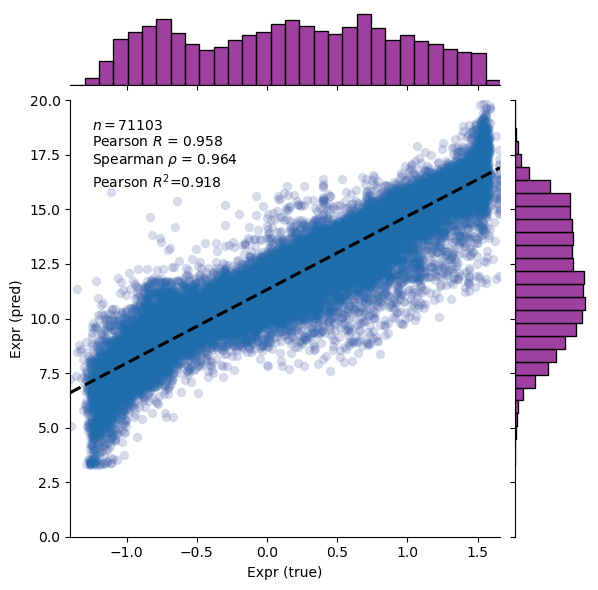

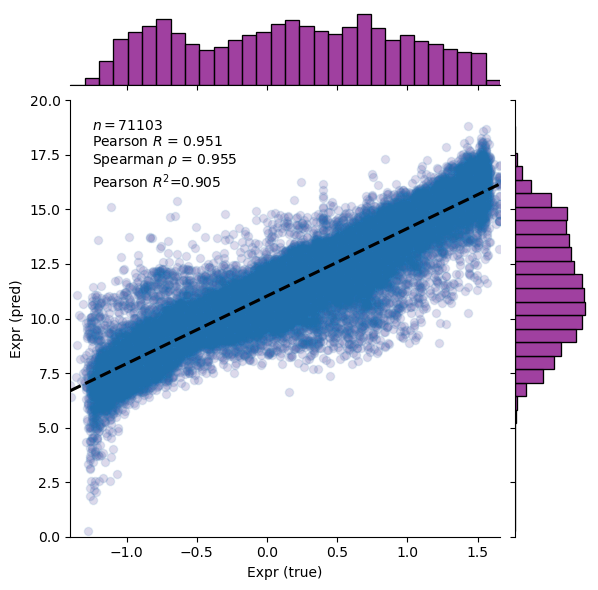

In [4]:
#Original model
ground_truth_file = "./OfficialEval/filtered_test_data_with_MAUDE_expression.txt"
pred_file = "./testing_results_tr0.9/challenge_testset_final_models/9_onehot_L1_AdamW_ReduceLROnPlateau/42/seq_predexpr.csv"

df = pd.read_csv(ground_truth_file, header=None, delimiter="\t", names=["seq","expr"])
df_hat = pd.read_csv(pred_file, header=None, delimiter="\t", names=["seq","expr"])

x = df["expr"]
y = df_hat["expr"]

plot_nice_scatter(x=x, y=y, normalise=False, ylims=[0,20])

#Mini model
pred_file = "./testing_results_tr0.9/challenge_testset_final_models/219_onehotWithP_MSE_AdamW_ReduceLROnPlateau/42/seq_predexpr.csv"

df = pd.read_csv(ground_truth_file, header=None, delimiter="\t", names=["seq","expr"])
df_hat = pd.read_csv(pred_file, header=None, delimiter="\t", names=["seq","expr"])

x = df["expr"]
y = df_hat["expr"]

plot_nice_scatter(x=x, y=y, normalise=False, ylims=[0,20])

Random seed set to 42; Cudnn benchmarking is False.
Number of sequences passed to encode	: 63814
Dropped due to more N count (> 3)	: 0
Dropped due to outside length spec	: 0

Data saved to ./manuscript/coloured_scatter_privatete_SI.csv


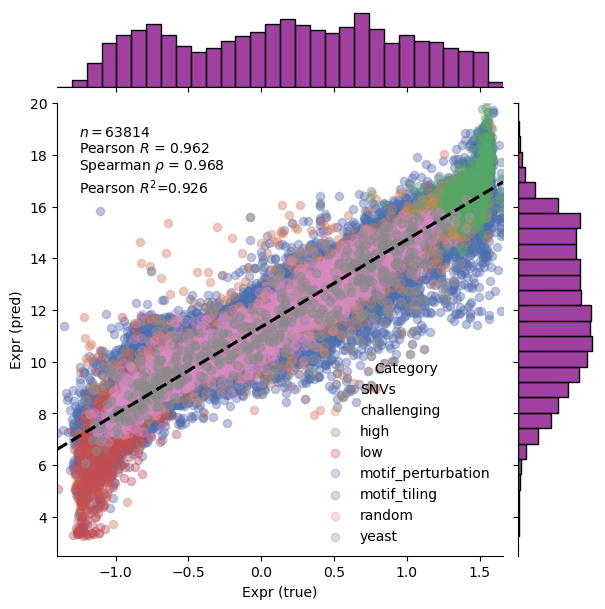

In [4]:
ground_truth_file = "./OfficialEval/filtered_test_data_with_MAUDE_expression_annotated.txt"
df = pd.read_csv(ground_truth_file, delimiter=",")
df = df[df["split"] == "private"]
seq = df[["seq"]]
expr = df["expr"]

from base.model import CNN    
config = loadDict(path="./training_results_tr0.9/9_onehot_L1_AdamW_ReduceLROnPlateau/42", filename="config")
setSeeds(config["seed"])
TestLoader = createDataLoader(seq=seq, expr=expr, config=config)

model_args = config["model_args"]
model = CNN(**model_args)
model = torch.load(config["best_model_path"])
model.to(config["device"])
model.eval()

y_pred, y_true = predict(model=model, DataLoader=TestLoader, config=config)
plot_annotated_scatter(x=y_true, y=y_pred, categories=df["category"], normalise=False, ylims=[2.5, 20], save_as=f"{FIG_PATH}/coloured_scatter_privatete_SI")

20
Model


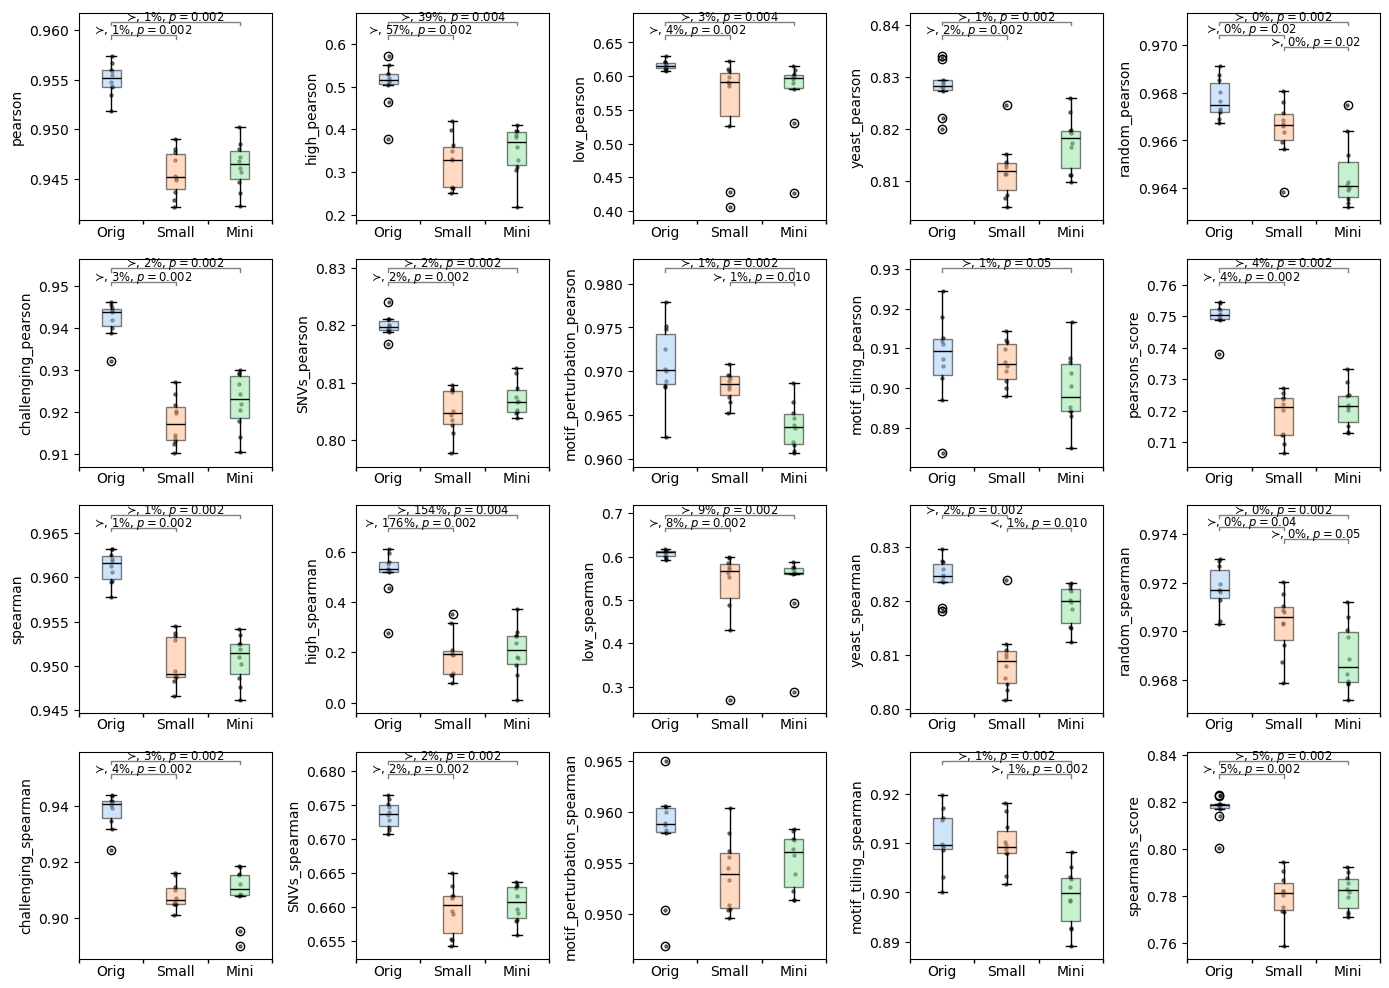

In [6]:
metrics = ["pearson", "high_pearson", "low_pearson", "yeast_pearson", "random_pearson", "challenging_pearson", "SNVs_pearson", 
           "motif_perturbation_pearson", "motif_tiling_pearson", "pearsons_score",
           "spearman", "high_spearman", "low_spearman", "yeast_spearman", "random_spearman", "challenging_spearman", "SNVs_spearman", 
           "motif_perturbation_spearman", "motif_tiling_spearman", "spearmans_score"]
print(len(metrics))

df_pub, df_pvt = getFinalScores()
columns = metrics

df = df_pvt

fig, axs = plt.subplots(4, 5, figsize=(14, 10))

box_group = "Model"
print(box_group)

order = [3,4,2]

for i, col in enumerate(columns):
    target = col

    df_subset = df[[box_group, target]]
    
    groupby_obj = df.groupby(box_group, sort=False)
    data = [group[target].to_numpy() for _, group in groupby_obj]
    labels = [label for label, _ in groupby_obj]

    data = [data[k] for k in order]
    labels = [labels[k] for k in order]

    title = ""
    ylabel = target
    
    # Use correct subplot index
    ax = axs[i // 5, i % 5]
    ax.set_title(target)  # Set subplot title
    xticklabels = labels
    _, _ = plot_box_and_whisker(data, title, ylabel, xticklabels, show_n=False, show_p=True, show_swarmplot=True, filepath=None, ax=ax)

plt.tight_layout()
plt.show()

Box plots comparing Camformer and LegNet:


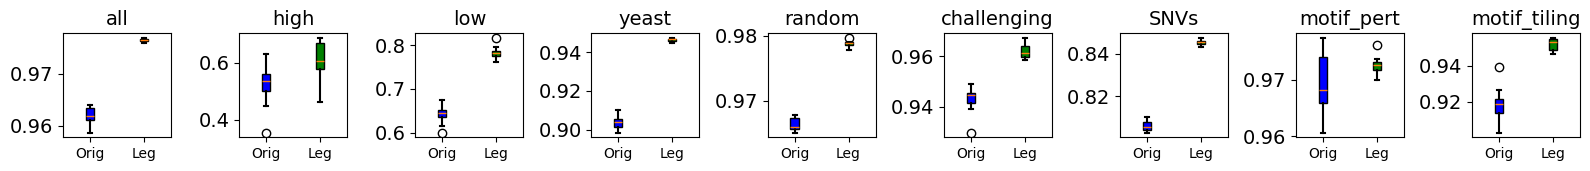

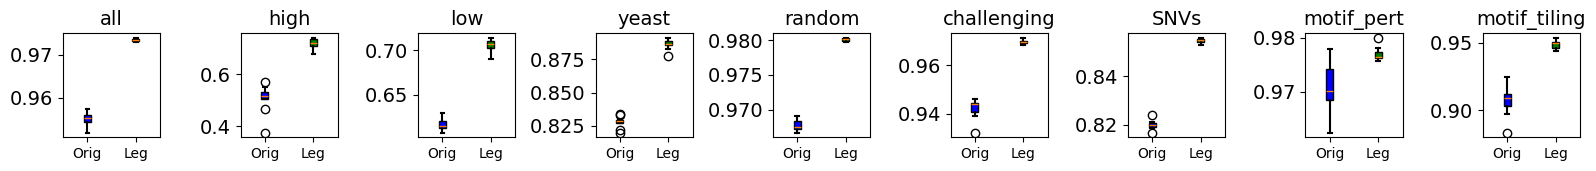

In [11]:
df_pub, df_pvt = getFinalScores()

print("Box plots comparing Camformer and LegNet:")
plot_box_plots_avg(df=df_pub, title="Public")
plot_box_plots_avg(df=df_pvt, title="Private")

Radar plots comparing all models:


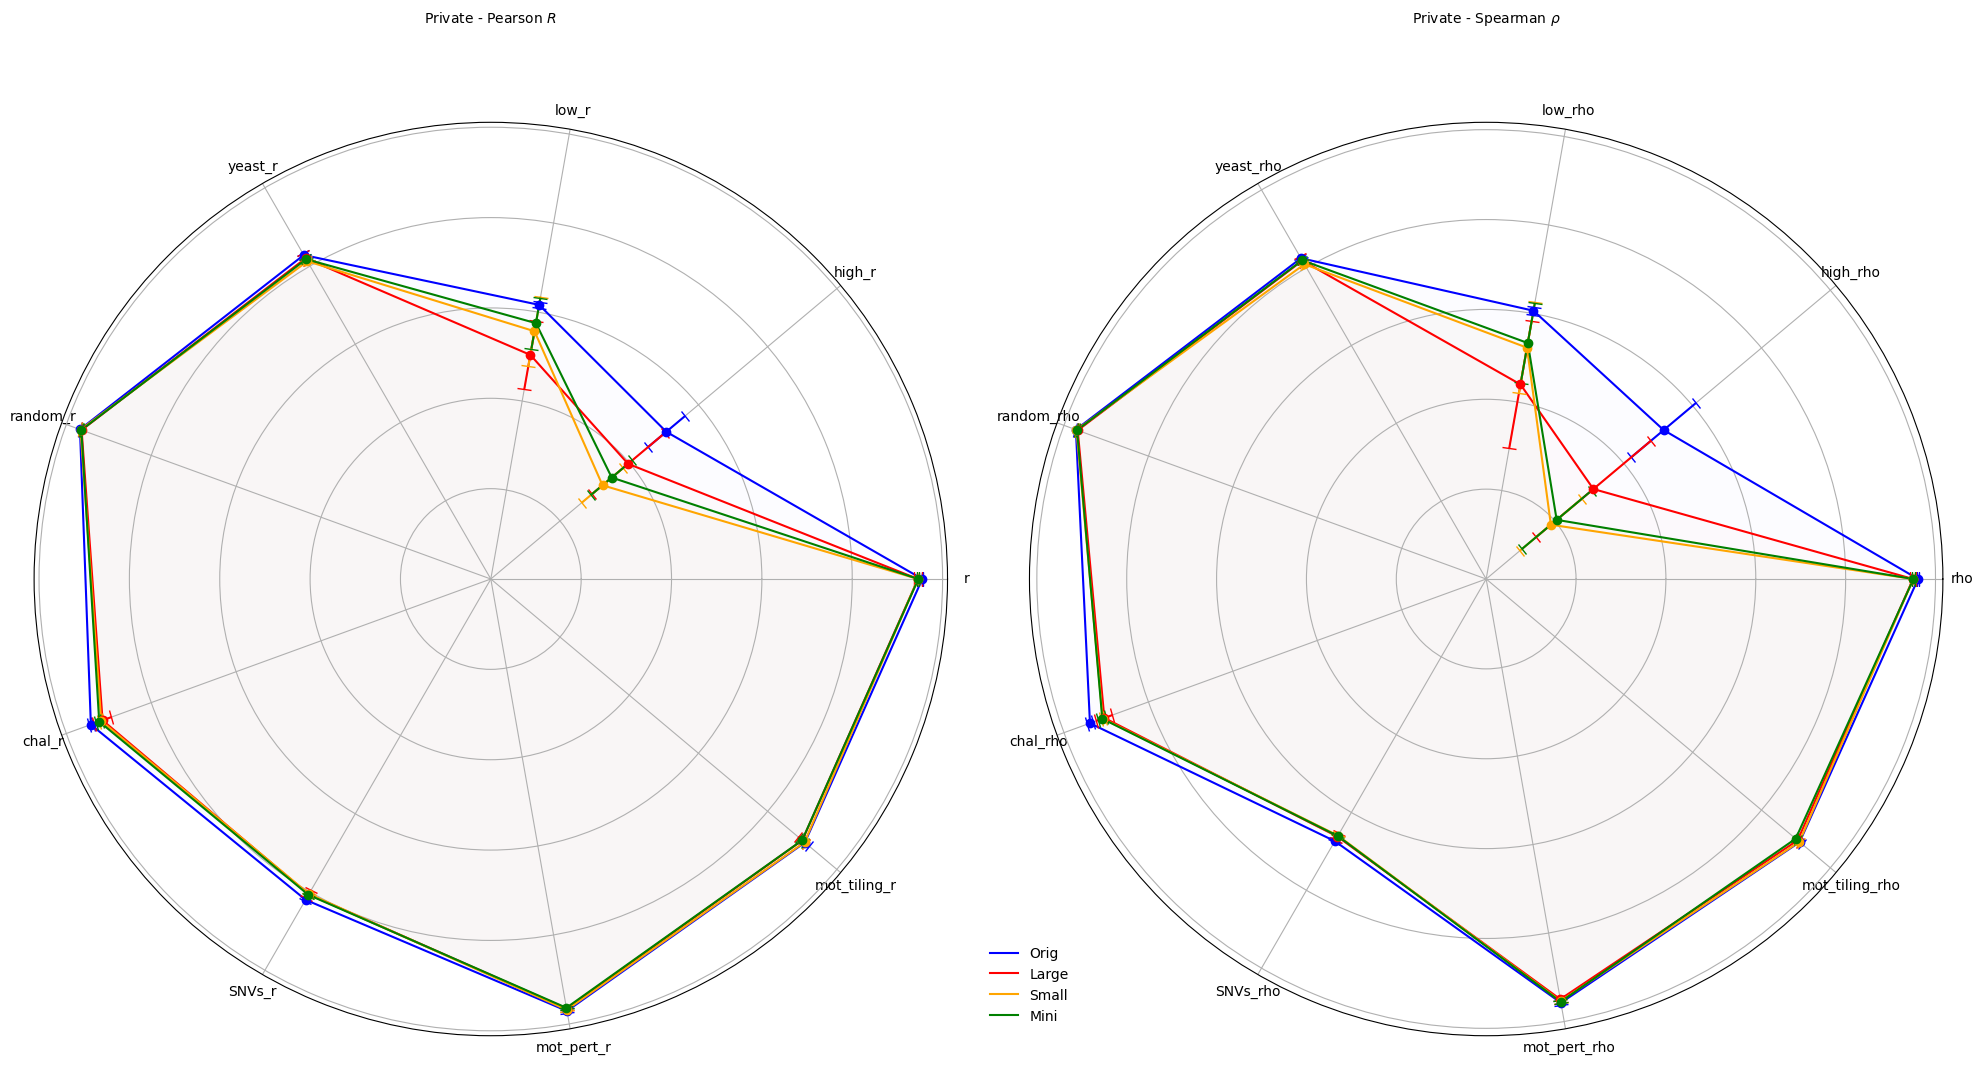

In [12]:
print("Radar plots comparing all models:")
df_pub, df_pvt = getFinalScores()
plot_radar_plots_avg(df=df_pvt, title="Private")

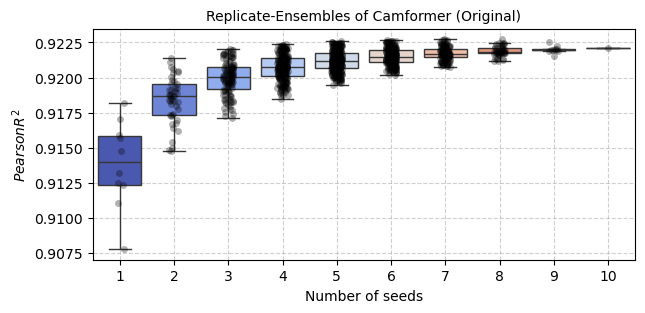

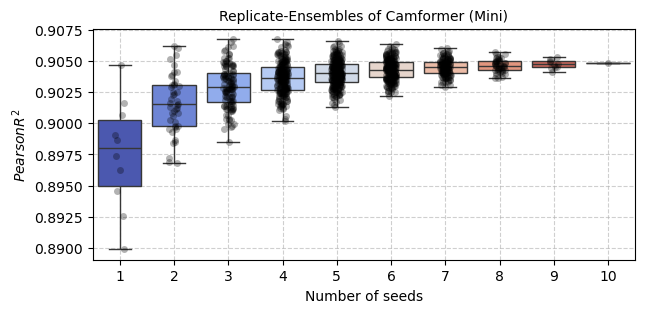

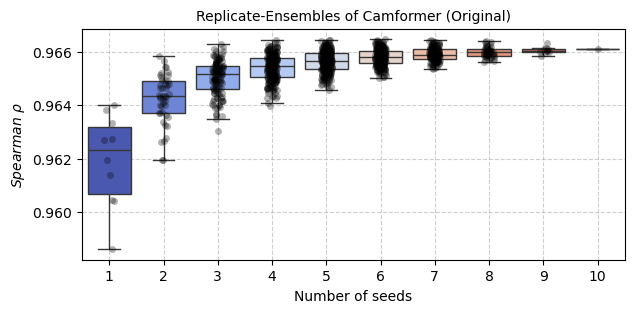

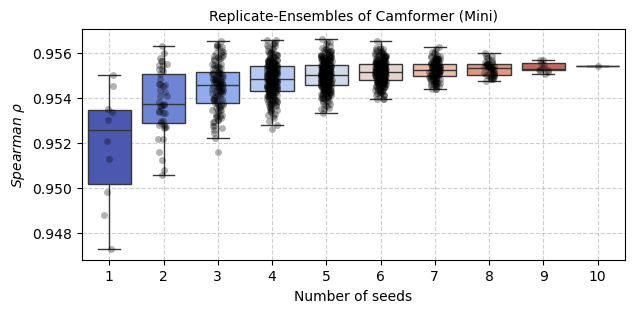

In [4]:
choices = ["PearsonR2", "SpearmanR"]

# Load ground truth expressions
true_file = "OfficialEval/filtered_test_data_with_MAUDE_expression.txt"
df_true = pd.read_csv(true_file, delimiter="\t", header=None)
df_true.columns = ["seq", "expr"]
Y_true = df_true["expr"].values

for choice in choices:
    ### Load predicted expressions from the Original model
    pred_dir = "testing_results_tr0.9/challenge_testset_final_models/9_onehot_L1_AdamW_ReduceLROnPlateau"
    SEEDS = [42, 23, 47, 56, 89, 12, 34, 78, 67, 98]
    df_preds = [pd.read_csv(f"{pred_dir}/{seed}/seq_predexpr.csv", delimiter="\t", header=None) for seed in SEEDS]
    Y_preds = [df_pred.iloc[:, 1].values for df_pred in df_preds]

    gen_ensemble_boxplots_unscaled(Y_preds=Y_preds, Y_true=Y_true, model_type="Original", choice=choice)

    ### Load predicted expressions for the Mini model
    pred_dir = "testing_results_tr0.9/challenge_testset_final_models/219_onehotWithP_MSE_AdamW_ReduceLROnPlateau"
    SEEDS = [42, 23, 47, 56, 89, 12, 34, 78, 67, 98]
    df_preds = [pd.read_csv(f"{pred_dir}/{seed}/seq_predexpr.csv", delimiter="\t", header=None) for seed in SEEDS]
    Y_preds = [df_pred.iloc[:, 1].values for df_pred in df_preds]

    gen_ensemble_boxplots_unscaled(Y_preds=Y_preds, Y_true=Y_true, model_type="Mini", choice=choice)

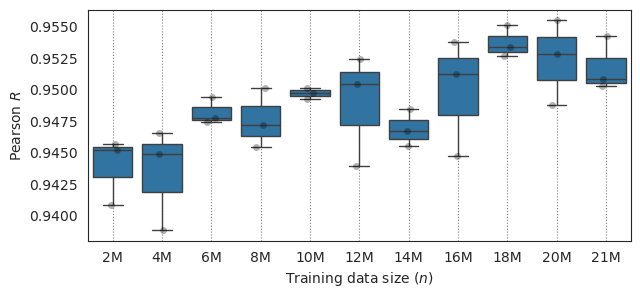

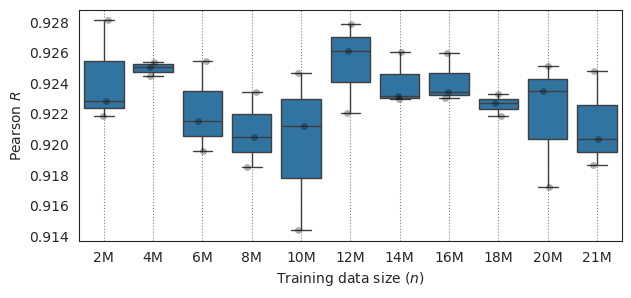

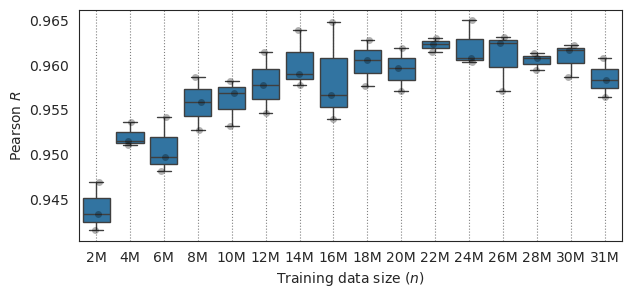

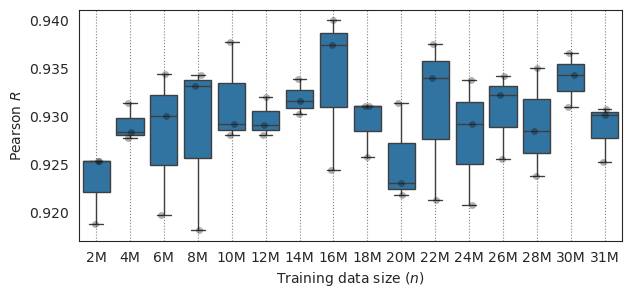

In [15]:
reload(plot_utils)

original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

trainingdata_vs_perfs_allseeds(input_file="data/media/LegNet_eval/Native_defined.csv", 
                               parent_dir="training_results_media_tr0.9/defined_media_training_data_SC_Ura/9_onehot_L1_AdamW_ReduceLROnPlateau")
                               #save_as=f"{FIG_PATH}/Native_defined_Camformer_trn_seeds")

trainingdata_vs_perfs_allseeds(input_file="data/media/LegNet_eval/Native_defined.csv", 
                               parent_dir="training_results_media_tr0.9/defined_media_training_data_SC_Ura/219_onehotWithP_MSE_AdamW_ReduceLROnPlateau")
                               #save_as=f"{FIG_PATH}/Native_defined_Camformer-Mini_trn_seeds")

trainingdata_vs_perfs_allseeds(input_file="data/media/LegNet_eval/Native_complex.csv", 
                               parent_dir="training_results_media_tr0.9/complex_media_training_data_Glu/9_onehot_L1_AdamW_ReduceLROnPlateau")
                               #save_as=f"{FIG_PATH}/Native_complex_Camformer_trn_seeds")

trainingdata_vs_perfs_allseeds(input_file="data/media/LegNet_eval/Native_complex.csv", 
                               parent_dir="training_results_media_tr0.9/complex_media_training_data_Glu/219_onehotWithP_MSE_AdamW_ReduceLROnPlateau")
                               #save_as=f"{FIG_PATH}/Native_complex_Camformer-Mini_trn_seeds")

sys.stdout.close()
sys.stdout = original_stdout

**Boot-strapped performance of different models (Fig 6)**

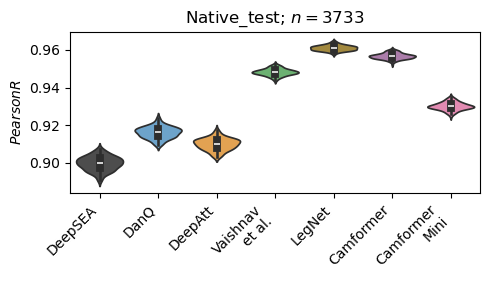

In [8]:
model_pred_files = {
    'DeepSEA': "~/SBLab/evolution/manuscript_code/model/results_summary/Native_test_DeepSEA_model.csv",
    'DanQ': "~/SBLab/evolution/manuscript_code/model/results_summary/Native_test_DanQ_model.csv",
    'DeepAtt': "~/SBLab/evolution/manuscript_code/model/results_summary/Native_test_DeepAtt_model.csv",
    'Vaishnav\net al.': "~/SBLab/evolution/manuscript_code/model/results_summary/Native_test_gpu_model.csv",
    'LegNet':"./data/media/LegNet_eval/Native_complex_matchingseqs.csv",
    'Camformer': "./results/Camformer_predictions/Native_test_Camformer_model.csv",
    'Camformer\nMini': "./results/Camformer_predictions/Native_test_Camformer-Mini_model.csv"
}

generate_bootstrap_violin_plots(model_pred_files, n_bootstrap=100, fig_title="Native_test") #set n_bootstra=10000, for reproducing fig in the paper

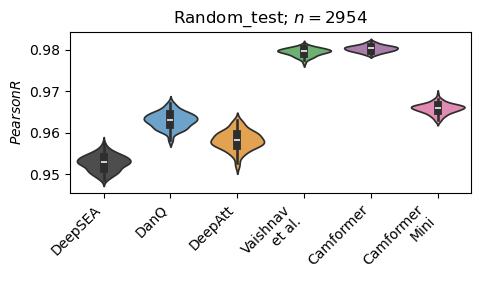

In [9]:
model_pred_files = {
    'DeepSEA': "~/SBLab/evolution/manuscript_code/model/results_summary/Random_test_DeepSEA_model.csv",
    'DanQ': "~/SBLab/evolution/manuscript_code/model/results_summary/Random_test_DanQ_model.csv",
    'DeepAtt': "~/SBLab/evolution/manuscript_code/model/results_summary/Random_test_DeepAtt_model.csv",
    'Vaishnav\net al.': "~/SBLab/evolution/manuscript_code/model/results_summary/Random_test_gpu_model.csv",
    'Camformer': "./results/Camformer_predictions/Random_test_Camformer_model.csv",
    'Camformer\nMini': "./results/Camformer_predictions/Random_test_Camformer-Mini_model.csv"
}

generate_bootstrap_violin_plots(model_pred_files, n_bootstrap=100, fig_title="Random_test") #set n_bootstra=10000, for reproducing fig in the paper

**Showing embeddings from Camformer at various layers (Fig 6)**

In [4]:
from base.plot_utils import scale_predictions
from base.emb_utils import plot_hist_tsne

In [5]:
#Check if the sampled file exists
file_path = "./stored_embs/sampled_data.csv"

if os.path.exists(file_path):
    print(f"The file '{file_path}' exists. So, just running visualisation.")
    df_sampled = pd.read_csv(file_path)
    num_quantiles = len(df_sampled["quantile"].unique())
    df_sampled["quantile"] = pd.Categorical(df_sampled["quantile"], categories=[f'Q{i+1}' for i in range(num_quantiles)], ordered=True)
else:
    print(f"The file '{file_path}' does not exist. Re-running the Camformer embeddings extraction.")
    df = pd.read_csv("OfficialEval/filtered_test_data_with_MAUDE_expression.txt", header=None, names=["seq","expr"], delimiter="\t")
    df_sampled = df.sample(n=10000, random_state=42)
    num_quantiles = 6
    df_sampled["quantile"], bins = pd.qcut(df_sampled["expr"], num_quantiles, labels=[f'Q{i+1}' for i in range(num_quantiles)], retbins=True)
    print(f"Quantile bins: {bins}")
    today_date = datetime.now().strftime("%Y-%m-%d")
    df_sampled.to_csv(f"./stored_embs/sampled_data_{today_date}.csv", index=False)

The file './stored_embs/sampled_data.csv' exists. So, just running visualisation.


In [6]:
### Load model, config and run prediction to extract the embeddings from each layer
config = loadDict(path="training_results_tr0.9/9_onehot_L1_AdamW_ReduceLROnPlateau/42") #Camformer Original
setSeeds(config["seed"])

model_args = config['model_args']
model = CNN(**model_args)
model = torch.load(config['best_model_path'])
model.to(config['device'])
model.eval()

config["batch_size"] = 256

seqs, exprs = df_sampled[["seq"]], df_sampled["expr"]
TestLoader = createDataLoader(seqs, exprs, config=config, isTest=True, drop=False)

for (X, y) in TestLoader:
    output = X.to(config["device"])
    print("Input:")
    print(f"\t{output.shape}")

    print("\nCNN Layers:")
    for layer in model.CNN_layers:
        output = layer(output)
        print(f"\t{output.shape}")

    output = output.view(output.size(0), -1)
    
    print("\nLinear Layers and Output:")
    for layer in model.linear_layers:
        output = layer(output)
        print(f"\t{output.shape}")
    break

# get predictions
y_pred, y_true = predict(model=model, DataLoader=TestLoader, config=config)
y_pred = scale_predictions(y_pred, y_true)
print(f"\nPredictions computed. ({len(y_pred)}, {len(y_true)})")

Random seed set to 42; Cudnn benchmarking is False.
Number of sequences passed to encode	: 10000
Dropped due to more N count (> 3)	: 0
Dropped due to outside length spec	: 0

Input:
	torch.Size([256, 4, 110, 1])

CNN Layers:
	torch.Size([256, 512, 110, 1])
	torch.Size([256, 512, 110, 1])
	torch.Size([256, 512, 110, 1])
	torch.Size([256, 512, 110, 1])
	torch.Size([256, 512, 26, 1])
	torch.Size([256, 512, 26, 1])

Linear Layers and Output:
	torch.Size([256, 256])
	torch.Size([256, 256])
	torch.Size([256, 1])

Predictions computed. (10000, 10000)


Conv Layer 5 output shape: torch.Size([10000, 512, 26, 1]), Errors length: 10000, Quantile length: 10000


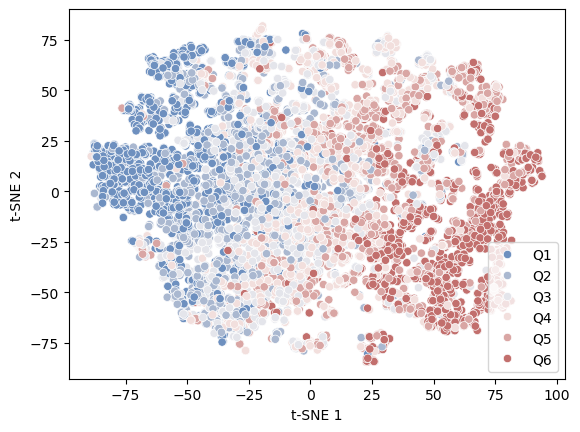

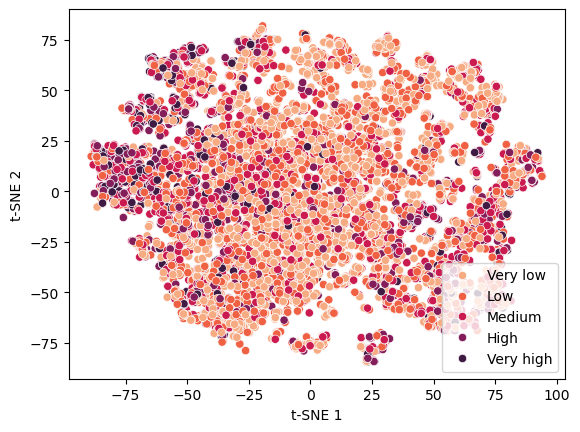

In [8]:
### t-SNE plots with mean CNN embeddings (Conv Layers: flattened) with legends: (1) Quantiles of expressions; (2) Quantiles of prediction errors
error_categories = ["Very low", "Low", "Medium", "High", "Very high"]

run = True

if run:
    for layer_idx in [5]:  #range(len(model.CNN_layers)):
        layer_output = []
        quantiles = []
        error_class = []
    
        for (X, y) in TestLoader:
            output = X.to(config['device'])
    
            for i, layer in enumerate(model.CNN_layers):
                if i > layer_idx:
                    break
                output = layer(output)
            
            output_cpu = output.cpu().detach()
            layer_output.append(output_cpu)
    
            y_pred_batch = y_pred[:len(y)]  # Get the corresponding predictions for the batch
            y_pred_error = np.abs(np.array(y_pred_batch) - np.array(y))  # error
    
            quantiles.extend(pd.qcut(y, num_quantiles, labels=[f'Q{i+1}' for i in range(num_quantiles)]))
            error_class.extend(pd.cut(y_pred_error, bins=len(error_categories), labels=error_categories, include_lowest=True))
                
        stacked_layer_outputs = torch.cat(layer_output, dim=0)
        
        print(f"Conv Layer {layer_idx} output shape: {stacked_layer_outputs.shape}, Errors length: {len(error_class)}, Quantile length: {len(quantiles)}")
    
        quantiles = pd.Categorical(quantiles, categories=[f'Q{i+1}' for i in range(num_quantiles)], ordered=True)
        error_class = pd.Categorical(error_class, categories=error_categories, ordered=True)
        
        plot_hist_tsne(stacked_layer_outputs, quantiles, layer="conv", plot_hist=False, plot_tsne=True, color_palette="vlag")
        plot_hist_tsne(stacked_layer_outputs, error_class, layer="conv", plot_hist=False, plot_tsne=True)

**Grad-CAM visualisations (Fig S?)**: Showing here a single sequence execution.

In [9]:
from base.gradcam_utils import plot_layerwise_logo

In [10]:
config = loadDict(path="training_results_tr0.9/9_onehot_L1_AdamW_ReduceLROnPlateau/42") #Camformer Original
setSeeds(config["seed"])
model_args = config["model_args"]
model = CNN(**model_args)
model = torch.load(config["best_model_path"])
model.to(config["device"])
model.eval()

Random seed set to 42; Cudnn benchmarking is False.


CNN(
  (CNN_layers): ModuleList(
    (0): Sequential(
      (0): Conv2dSame(
        (conv): Conv2d(4, 512, kernel_size=(10, 1), stride=(1, 1))
      )
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=[1, 1], stride=[1, 1], padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.3, inplace=False)
    )
    (1-3): 3 x Sequential(
      (0): Conv2dSame(
        (conv): Conv2d(512, 512, kernel_size=(10, 1), stride=(1, 1))
      )
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=[1, 1], stride=[1, 1], padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.3, inplace=False)
    )
    (4): Sequential(
      (0): Conv2dSame(
        (conv): Conv2d(512, 512, kernel_size=(10, 1), stride=(1, 1))
      )
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Number of sequences passed to encode	: 1
Dropped due to more N count (> 3)	: 0
Dropped due to outside length spec	: 0

Layer 5


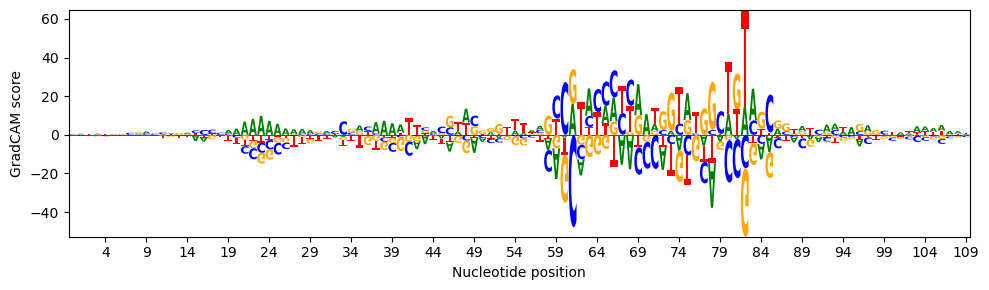

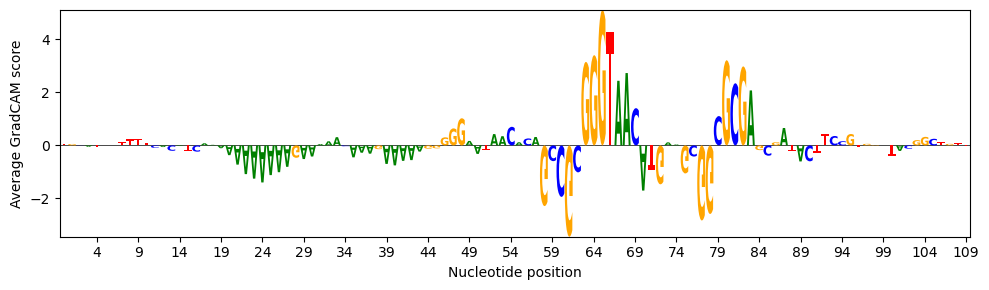

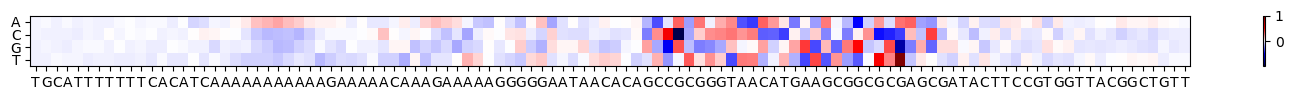

In [11]:
df = pd.DataFrame(columns=["seq","expr"])
df["seq"] = ["TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAACAAAGAAAAAGGGGGAATAACACAGCCGCGGGTAACATGAAGCGGCGCGAGCGATACTTCCGTGGTTACGGCTGTT"]
df["expr"] = [0.966727069012904]
config["batch_size"] = 1
TestLoader = createDataLoader(df[["seq"]], df["expr"], config=config, isTest=True)
plot_layerwise_logo(model, config, TestLoader, layer_idx=5, num_samples=1)

**In silico mutagenesis (ISM) visualisations (Fig. S?)**: Showing here an execution for a single sequence.

In [12]:
from base.ism_utils import generate_mutations, generate_logo_w_flanking

240 mutations for sequence: TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAACAAAGAAAAAGGGGGAATAACACAGCCGCGGGTAACATGAAGCGGCGCGAGCGATACTTCCGTGGTTACGGCTGTT [0.97]
Generating ISM logos for: TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAACAAAGAAAAAGGGGGAATAACACAGCCGCGGGTAACATGAAGCGGCGCGAGCGATACTTCCGTGGTTACGGCTGTT
Number of sequences passed to encode	: 1
Dropped due to more N count (> 3)	: 0
Dropped due to outside length spec	: 0

Number of sequences passed to encode	: 240
Dropped due to more N count (> 3)	: 0
Dropped due to outside length spec	: 0



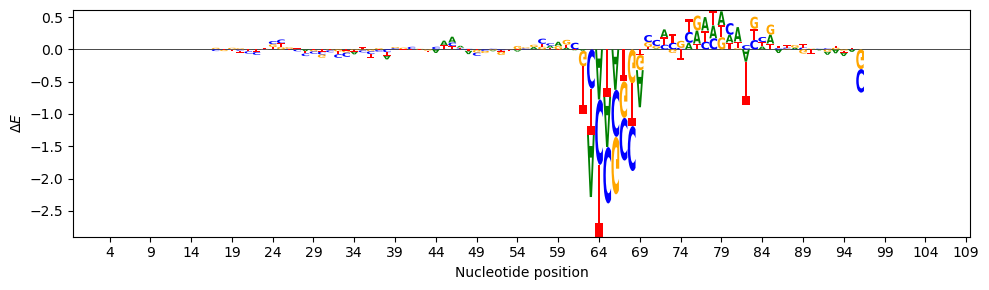

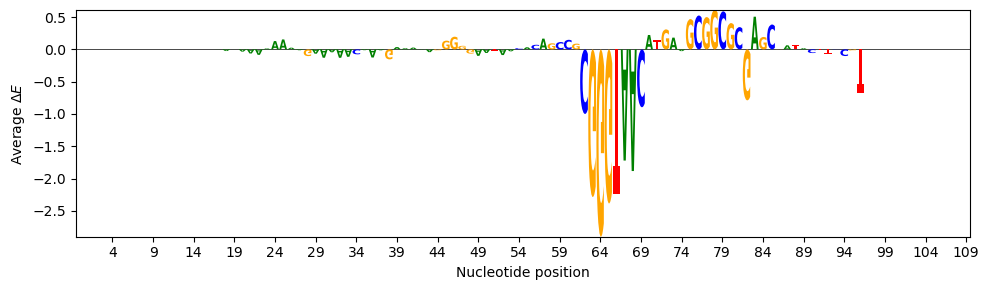

True

In [13]:
seq, expr = "TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAACAAAGAAAAAGGGGGAATAACACAGCCGCGGGTAACATGAAGCGGCGCGAGCGATACTTCCGTGGTTACGGCTGTT", 0.966727069012904

mutations = generate_mutations(seq)
print(f"{len(mutations)} mutations for sequence: {seq} [{expr:.2f}]")
generate_logo_w_flanking(model, config, seq, expr, entropy_thres=7)